## Figure 2: Illustrative Explanation of the idea based on the toy example

In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from loss_cal.tasks.toy_example import ToyExample
from loss_cal.npe import load_npes
from loss_cal.bam import load_predictors
from loss_cal.costs import RevGaussCost, expected_posterior_costs_given_posterior_samples
from loss_cal.utils.analysis import find_optimal_action


plot_config_file = "loss_cal/utils/.matplotlibrc"
plt.rcParams.update(mpl.rc_params_from_file(fname=plot_config_file))

color_npe = "#377eb8"
color_nn = "#ff7f00"
color_post = "#4daf4a"
save_dir = "./paper/fig2/"

figsize=(1.9,1.2)
seed = 0 

In [3]:
mpl.matplotlib_fname()

'/Users/mgorecki/opt/miniconda3/envs/losscal-py310/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'

In [4]:
action_type="continuous"
toy = ToyExample(action_type=action_type)
factor, exponential = 2, 2

parameter_range = [toy.param_low[0].squeeze().item(), toy.param_high[0].squeeze().item()]
action_range = [toy.action_low, toy.action_high]

cost_fn = RevGaussCost(
    parameter_range=parameter_range, action_range=action_range, factor=factor, exponential=exponential
)

### Load NPE

In [ ]:
flow = "maf"# "nsf" #
npe_posteriors, num_simulations_npe = load_npes(f"./results/toy_example/npe/{seed}/", flow=flow)

In [6]:
num_samples = 1000

### Load NN

In [ ]:
experiment = "vary_sim"
task_name = "toy_example"
num_action_samples = "inloop" #"100actions"
dir = f"./results/{task_name}/{action_type}/nn/fc/{experiment}/{seed}/{num_action_samples}/*_factor_{factor}_exp_{exponential}/"
print(dir)
models, num_simulations_nn = load_predictors(task_name, action_type="continuous", dir=dir)

In [8]:
num_simulations = 1_000
model = models[num_simulations_nn.index(2*num_simulations)]
npe_posterior = npe_posteriors[num_simulations_npe.index(5*num_simulations)]

## Plotting

In [9]:
x_o = torch.Tensor([140.])

### Panel A: Joint

/Users/mgorecki/opt/miniconda3/envs/losscal-py310/lib/python3.10/site-packages/matplotlib/ticker.py:1717: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  self.locs = np.asarray(locs)


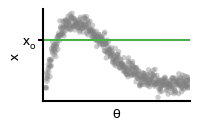

In [10]:

# plt.rcParams["axes.spines.top"]=True
# plt.rcParams["axes.spines.right"]=True
fig, ax = plt.subplots(1, 1, figsize=figsize)
thetas = torch.linspace(0, 5, 500)
ax.scatter(thetas, toy.get_simulator()(thetas), c='grey', alpha=0.4, s=15, edgecolors='none')
ax.hlines(y=x_o, xmin=thetas.min().item()-0.1, xmax= thetas.max().item(), colors=color_post, linestyles='solid')
# ax.set_xticklabels("")
ax.tick_params(axis="y", pad=1)
ax.set_yticks([x_o])
ax.set_yticklabels([r"$x_o$"])
ax.xaxis.set_major_locator(mpl.ticker.NullLocator())
# ax.yaxis.set_major_locator(mpl.ticker.NullLocator())
ax.set_xlabel(r"$\theta$")
ax.set_ylabel("x", labelpad=0)
ax.set_xlim(thetas.min().item()-0.1, thetas.max().item())
#ax.set_title("joint")
plt.savefig('./paper/fig2/panel_a.svg')

plt.show()

### Panel B: posterior distribution

/Users/mgorecki/Documents/projects/loss-calibration/code/loss-cal/loss_cal/tasks/toy_example.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(mean).to(self.device),


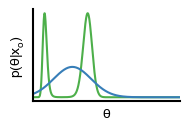

In [11]:
resolution = 1000
posterior_evals = toy.gt_posterior(torch.Tensor([x_o]))
# plt.rcParams["axes.spines.top"]=True
# plt.rcParams["axes.spines.right"]=True
fig, ax = plt.subplots(1, 1, figsize=figsize)
thetas = torch.linspace(toy.param_low.item(), toy.param_high.item(), resolution)
ax.plot(thetas, posterior_evals, c=color_post, label="posterior")
ax.plot(thetas, npe_posterior.log_prob(thetas.reshape(-1, 1), x=x_o).exp(), c=color_npe, label=f"NPE-MC")
ax.xaxis.set_major_locator(mpl.ticker.NullLocator())
ax.yaxis.set_major_locator(mpl.ticker.NullLocator())
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$p(\theta|x_o)$")
ax.set_xlim(toy.param_low.item(), toy.param_high.item())
#ax.set_title("ground truth")
#plt.legend()
plt.savefig('./paper/fig2/panel_b.svg')
plt.show()

### Panel C: Cost function

In [12]:
import matplotlib.style as style
style.use("seaborn-colorblind")

/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_18372/1083190338.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use("seaborn-colorblind")


/var/folders/94/0gpvl07x6ks__mzyr78t4gg00006zk/T/ipykernel_18372/1182182194.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("Greys", len(thetas)+3)


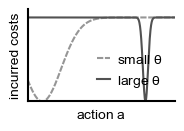

In [13]:
color_costs = "#984ea3"
linestyles = {0: {"linestyle": "dashed", "dashes":(3, 0.8)}, 1: {"linestyle": "solid"}} # ["dashed", "solid"]
# colors = cmap(torch.linspace(0, cmap.N, 10).numpy())

# plt.rcParams["axes.spines.top"]=True
# plt.rcParams["axes.spines.right"]=True
resolution = 1000
actions = torch.arange(toy.action_low, toy.action_high, (toy.action_high - toy.action_low) / resolution)

fig, ax = plt.subplots(1, 1, figsize=figsize)
thetas = torch.Tensor([0.5,4.]) #torch.arange(toy.param_low.item(), toy.param_high.item()+0.01, 1.2)
cmap = mpl.cm.get_cmap("Greys", len(thetas)+3)
# ax.set_prop_cycle(color=["#0072B2", "#009E73", "#D55E00", "#CC79A7","#F0E442", "#56B4E9"])
labels = [r"small $\theta$", r"large $\theta$"]
for i, theta in enumerate(thetas):
    ax.plot(actions, cost_fn(theta, actions), label=labels[i],  c=cmap(i+2), **linestyles[i]) #c=f"C{i}")#,

ax.xaxis.set_major_locator(mpl.ticker.NullLocator())
ax.yaxis.set_major_locator(mpl.ticker.NullLocator())
ax.set_xlabel(r"action $a$")
ax.set_ylabel(r"incurred costs") # $\mathcal{C}(\theta, a)$")
ax.set_xlim(actions.min().item(), actions.max().item())
ax.set_ylim(0, 1.1)
ax.legend(handlelength=0.95, handletextpad=0.5)
# ax.legend(
#     loc="upper center",
#     bbox_to_anchor=(0.6, -0.15),
#     fancybox=True,
#     shadow=True,
#     ncol=6,
# )
legend_costs = ax.get_legend_handles_labels()
plt.savefig('./paper/fig2/panel_c.svg')
plt.show()

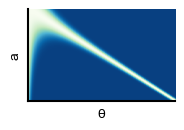

In [14]:
#cost_fn(thetas, actions.T).shape

resolution = 1000
actions = torch.arange(toy.action_low, toy.action_high+0.001, (toy.action_high - toy.action_low) / resolution).unsqueeze(1)
thetas = torch.arange(toy.param_low.item(), toy.param_high.item()+0.001, 0.01).unsqueeze(1)

fig, ax = plt.subplots(1, 1, figsize=figsize)
im=ax.imshow(cost_fn(thetas, actions.T).T, aspect="auto", cmap="GnBu", vmin=0, vmax=1)
ax.set_xticks([])#ticks=thetas.numpy().squeeze()[::100]*100, labels= thetas.numpy()[::100].squeeze())
ax.set_yticks([]) #ticks=actions.numpy().squeeze()[::200]*10, labels= actions.numpy()[::200].squeeze())
ax.set_ylabel(r"$a$")
ax.set_xlabel(r"$\theta$")
#fig.colorbar(im, orientation='vertical')
# plt.savefig('./paper/fig2/panel_c.svg')
plt.show()

### Panel D: expected costs

Compute Expected Costs

In [15]:
a_grid = torch.arange(toy.action_low, toy.action_high, 0.5)
expected_posterior_costs = toy.expected_posterior_costs(x=x_o, a=a_grid, cost_fn=cost_fn).squeeze()
predicted_costs_nn = model(x_o.repeat(a_grid.shape), a_grid).detach()

npe_samples = npe_posterior.sample((num_samples * 10,), x=x_o, show_progress_bars=False)
predicted_costs_npe = expected_posterior_costs_given_posterior_samples(
    post_samples=npe_samples, actions=toy.actions, a=a_grid, param=0, cost_fn=cost_fn
).squeeze()

/Users/mgorecki/Documents/projects/loss-calibration/code/loss-cal/loss_cal/tasks/toy_example.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(mean).to(self.device),


Find optimal actions

In [16]:
post_action, _, post_costs = find_optimal_action(
    x_o, task=toy, method="posterior", cost_fn=cost_fn, param=0, verbose=False
)
nn_action, nn_estimated_costs, nn_costs = find_optimal_action(
    x_o, task=toy, method="nn", nn=model, cost_fn=cost_fn, param=0, verbose=False
)
npe_action, npe_estimated_costs, npe_costs = find_optimal_action(
    x_o, task=toy, method="npe", npe=None, npe_samples=npe_samples, cost_fn=cost_fn, param=0, verbose=False
)

Plot

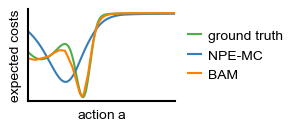

In [17]:

# plt.rcParams["axes.spines.top"]=True
# plt.rcParams["axes.spines.right"]=True
fig, ax = plt.subplots(1, 1, figsize=figsize)

# expected costs
ax.plot(a_grid, expected_posterior_costs, c=color_post, label="ground truth")
ax.plot(a_grid, predicted_costs_npe, c=color_npe, label="NPE-MC")
ax.plot(a_grid, predicted_costs_nn, c=color_nn, label="BAM")
# optimal actions
# ax.scatter(post_action, post_costs, c=color_post, s=30)
# ax.scatter(nn_action, nn_costs, c=color_nn, s=30)
# ax.axvline(x=npe_action.item(), ymin=0, ymax=1, c=color_npe, linestyle='dashed')
# ax.axvline(x=post_action.item(), ymin=0, ymax=1, c=color_post, linestyle='dashed')
# ax.axvline(x=nn_action.item(), ymin=0, ymax=1, c=color_nn, linestyle='dashed')
#ax.scatter(nn_action, nn_estimated_costs, marker="o", facecolors="none", edgecolors=color_nn, s=30)
# ax.scatter(npe_action, npe_costs, c=color_npe, s=30)
#ax.scatter(npe_action, npe_estimated_costs, marker="o", facecolors="none", edgecolors=color_npe, s=30)

ax.xaxis.set_major_locator(mpl.ticker.NullLocator())
ax.yaxis.set_major_locator(mpl.ticker.NullLocator())
ax.set_xlabel(r"action $a$")
ax.set_ylabel(r"expected costs")# $\mathbb{E}_{p(\theta|x)}[ \mathcal{C}(\theta, a)]$") #[\mathcal(C)(\theta, a)]$")
ax.set_xlim(a_grid.min().item(), a_grid.max().item())

# ax.set_title("expected costs")

legend_methods = ax.get_legend_handles_labels()
handles = legend_methods[0]#+ legend_costs[0]
labels = legend_methods[1] #+ legend_costs[1]

plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5), handlelength=0.95, handletextpad=0.5)
plt.savefig('./paper/fig2/panel_d.svg')
plt.savefig('./paper/fig2/panel_d.png')
plt.show()

### Combine figures to one multipanel figure

In [18]:
import time
import IPython.display as IPd
from svgutils.compose import *

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}


text_wdth = "21.59cm" #"13.968cm" #"21.59cm"
f = Figure(text_wdth, "3.5cm",   #20.3 = width of document (check!)
  
      Panel(
            SVG("./paper/fig2/panel_a.svg").scale(svg_scale),
            Text("a", 10., 2.0, **kwargs_text),
      ).move(0, 20),
      
      Panel(
            SVG("./paper/fig2/panel_b.svg").scale(svg_scale),
            Text("b", 5., 2.0, **kwargs_text),
      ).move(180,20),
      
      Panel(
            SVG("./paper/fig2/panel_c.svg").scale(svg_scale),
            Text("c", 5., 2.0, **kwargs_text),
      ).move(350, 20),
      
      Panel(
            SVG("./paper/fig2/panel_d.svg").scale(svg_scale),
            Text("d", 5., 2.0, **kwargs_text),
      ).move(520, 20),
)

f

In [19]:
# !mkdir -p fig
f.save("./paper/fig2/fig2.svg")
# svg("./paper/fig2/fig2.png")